In [1]:
import torch

print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))


PyTorch Version: 2.5.1+cu121
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [2]:
# Move tensor operations to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create random tensors
a = torch.randn(3, 3).to(device)
b = torch.randn(3, 3).to(device)

# Perform matrix multiplication
result = torch.mm(a, b)

print("Tensor Computation on GPU:")
print(result)


Tensor Computation on GPU:
tensor([[ 0.3550,  1.6852, -0.7725],
        [ 0.2037, -3.4249,  1.6008],
        [-0.5354,  0.4984, -0.3330]], device='cuda:0')


In [3]:
import torch

# Create large matrices
matrixA = torch.rand(5000, 5000)  # Move to GPU
matrixB = torch.rand(5000, 5000)

# Matrix multiplication
result = torch.mm(matrixA, matrixB)
print(result)


tensor([[1255.1343, 1246.8629, 1257.0663,  ..., 1245.3501, 1253.5385,
         1243.4995],
        [1230.3698, 1230.8740, 1240.1144,  ..., 1233.4709, 1249.7870,
         1242.0094],
        [1273.0566, 1271.9705, 1256.6255,  ..., 1262.0961, 1267.4065,
         1265.0436],
        ...,
        [1245.3228, 1243.6532, 1244.3282,  ..., 1248.5726, 1263.6300,
         1246.3740],
        [1242.9178, 1249.6007, 1245.7539,  ..., 1243.4437, 1261.0182,
         1237.9288],
        [1270.8845, 1268.6421, 1264.0729,  ..., 1268.0360, 1270.5399,
         1262.8727]])


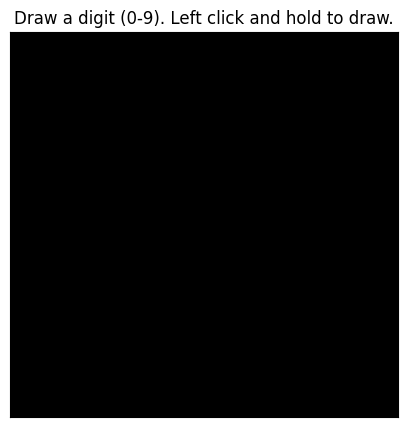

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Set device - GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define a simple feedforward neural network
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)  # 28x28 images (flattened to 784)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)  # 10 output classes (for digits 0-9)

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)  # Output layer (no activation for raw scores)
        return x

# Initialize model and move it to device
model = SimpleNN().to(device)

# Define the transformation for the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize the image (mean=0.5, std=0.5)
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set up loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(5):  # Train for 5 epochs
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device

        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs.view(-1, 28 * 28))  # Flatten images to 784 features
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Print stats after each epoch
    print(f"Epoch [{epoch+1}/5], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100*correct/total:.2f}%")

# Evaluate on the test set
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient calculation (faster and memory-efficient)
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move to device
        outputs = model(inputs.view(-1, 28 * 28))  # Flatten images to 784 features
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Print final accuracy on the test set
print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Function to handle user drawing on canvas
def draw_digit():
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xticks([])  # Remove x ticks
    ax.set_yticks([])  # Remove y ticks
    ax.set_facecolor('black')  # Set background to black

    # Initialize canvas (white background, for easier drawing)
    canvas = np.ones((28, 28)) * 255  # white canvas (for drawing)

    # Function to update the canvas as user draws
    def on_mouse_move(event):
        if event.button == 1:  # Left mouse button pressed
            x, y = int(event.xdata), int(event.ydata)
            if 0 <= x < 28 and 0 <= y < 28:  # Make sure coordinates are within the canvas
                canvas[y, x] = 0  # Draw black pixel where mouse moves

        ax.imshow(canvas, cmap='gray')
        fig.canvas.draw()

    fig.canvas.mpl_connect('motion_notify_event', on_mouse_move)
    plt.title("Draw a digit (0-9). Left click and hold to draw.")

    plt.show()

    # Wait for user to press Enter after drawing
    input("Press Enter when you're done drawing...")

    # Save the canvas as an image and process it
    image = Image.fromarray(canvas).convert('L')
    image = image.resize((28, 28))  # Resize to 28x28
    image = transform(image).unsqueeze(0).to(device)  # Convert to tensor and move to device

    return image

# Function to predict the drawn number
def predict_digit(image):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # No need for gradient calculation
        outputs = model(image.view(-1, 28 * 28))  # Flatten the image to 784 features
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        return predicted.item()  # Return the predicted digit

# Main program
if __name__ == "__main__":
    image = draw_digit()  # Let the user draw a digit
    predicted_digit = predict_digit(image)  # Predict the digit
    print(f"The predicted digit is: {predicted_digit}")
